## Intro

The webpage we have selected from the forums is titled 'Chronic Car Buyers Anonymous,' accessible at https://forums.edmunds.com/discussion/4011/general/x/chronic-car-buyers-anonymous. This group consists of individuals who frequently go car shopping and share their thoughts about various cars. Analyzing the discussions and preferences of this group provides valuable insights into consumer trends and preferences, which can significantly benefit automotive businesses in tailoring their marketing strategies and product development.

## 1. Data Scraping

In [ ]:
from bs4 import BeautifulSoup # documentation available at : www.crummy.com/software/BeautifulSoup/bs4/doc/
import requests # sends http requests and access the page : docs.python-requests.org/en/latest/
import csv # creates the output csv file
#import unicodedata # works with string encoding of the data

entries = []
entry = []
urlnumber = 2 # Give the page number to start with


while urlnumber < 150: # Give the page number to end with

    url = 'https://forums.edmunds.com/discussion/4011/general/x/chronic-car-buyers-anonymous/p%d' % (urlnumber,) # Give the url of the forum, excluding the page number in the hyperlink

    try:
        r = requests.get(url, timeout = 10) # Sending a request to access the page
    except Exception as e:
        print("Error message:",e)
        break;

    data = r.text
    
    soup = BeautifulSoup(data, 'lxml') # Getting the page source into the soup
    
    for div in soup.find_all('div'):
        entry = []
        if(div.get('class') != None and div.get('class')[0] == 'Comment'): # A single post is referred to as a comment. Each comment is a block denoted in a div tag which has a class called comment.
            ps = div.find_all('p') # gets all the tags called p to a variable ps
            aas = div.find_all('a') # gets all the tags called a to a variable aas
            spans = div.find_all('span')
            times = div.find_all('time') # used to extract the time tag which gives the iDate of the post

            concat_str = ''
            for str in aas[1].contents: # prints the contents that is between the tag start and end
                if str != "<br>" or str != "<br/>": # breaks in post which we need to work around
                    concat_str = (concat_str + ' '+ str).encode("utf-8").strip() # the format extracted is a unicode - we need a uniform structure to work with the strings
            entry.append(concat_str)

            concat_str = ''
            for str in times[0].contents:
                if str != "<br>" or str != "<br/>":
                    concat_str = (concat_str + ' '+ str).encode('iso-8859-1').strip()
            entry.append(concat_str)

            for div in div.find_all('div'):
                if (div.get('class') != None and div.get('class')[0] == 'Message'): # extracting the div tag with the class attribute as message
                    blockquotes = []
                    x = div.get_text()
                    for bl in div.find_all('blockquote'):
                        blockquotes.append(bl.get_text()) # block quote is used to get the quote made by a person. get_text helps to eliminate the hyperlinks and pulls out only the data.
                        bl.decompose()
                    # Encoding the text to ascii code by replacing the non-ascii characters
                    ascii_encoding = div.get_text().replace("\n"," ").replace("<br/>","").encode('ascii','replace')
                    # Convert the ASCII encoding to Latin1 encoding
                    latin1_encoding = ascii_encoding.decode('ascii').encode('iso-8859-1')
                    # Append the encoding bytes to output list
                    entry.append(latin1_encoding)

                    for bl in blockquotes:
                        ascii_encoding = bl.replace("\n"," ").replace("<br/>","").encode('ascii','replace')
                        latin1_encoding = ascii_encoding.decode('ascii').encode('iso-8859-1')
                        entry.append(latin1_encoding)

            entries.append(entry)
            
    urlnumber += 1

# Convert a list of byte to list a of string     
stringlist=[[x.decode('iso-8859-1') for x in entry] for entry in entries]
# Save the list to a csv file
with open('edmunds_extraction.csv', 'w') as output:
    writer = csv.writer(output, quoting=csv.QUOTE_ALL)
    writer.writerows(stringlist)

## 2. Data Pre-processing
The goal of this part is to 1) extract unique brand names from each comment, and 2) tokenize the comments so that further insights can be generated based on the key attributes mentioned. The output is a cleansed dataframe, which everyone can use to perform analytics based on their use cases. Additionally, the output is also saved as an Excel file for those who would like to review it firsthand.

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 200)

Loading the brands and models, clean up and change to lowercase; Creating a dictionary to store them in key value pairs

In [2]:
# Define a function to clean the text
def clean_text(text):
    # Replace or remove unwanted characters here
    text = text.replace(',', '').replace('.', '')
    return text.strip().lower()

# Read the csv file into a dataframe
brand_model_data = pd.read_csv('models.csv', header=None)
brand_model_data.columns = ['Brand', 'Model']

# Remove the row where the Brand is 'car'
brand_model_data = brand_model_data[brand_model_data['Brand'].str.lower() != 'car']
brand_model_data = brand_model_data[brand_model_data['Brand'].str.lower() != 'seat']
brand_model_data = brand_model_data[brand_model_data['Brand'].str.lower() != 'problem']

# Ensure the columns are named correctly
brand_model_data.columns = ['Brand', 'Model']

# Creating a dictionary with the brand as key and a list of unique models as value
brand_model_dict = {}
for index, row in brand_model_data.iterrows():
    # Apply cleaning function to brand and model
    brand = clean_text(row['Brand'])
    model = clean_text(row['Model'])

    if brand in brand_model_dict:
        # Add the model to the brand's list if it's not already there
        if model not in brand_model_dict[brand]:
            brand_model_dict[brand].append(model)
    else:
        brand_model_dict[brand] = [model]

# Formatting the output for better readability with all models
for brand, models in brand_model_dict.items():
    models_list = ", ".join(models)
    print(f"{brand}: {models_list}")

acura: integra, legend, vigor, rlx, ilx, mdx, rdx, tsx, rsx
audi: quattro, a4, a6, a5, a7, q3, q5, q7, a8, a3
bmw: 3-series, 5-series, 6-series, 4-series, xdrive, alpina, 330ci, 328i, 330c, 335i, 335d, 528i, 535i, 128i, 640i, 3er, 5er, m5, m3, m6, bmws, bmwesque
buick: park avenue, la crosse, lacrosse, century, enclave, encore, regal, buicks
cadillac: escalade, srx, xts
chevrolet: grand blazer, trailblazer, silverado, colorado, corvette, suburban, cavalier, caprice, captiva, equinox, express, lacetti, montana, uplander, orlando, tornado, tracker, traverse, camaro, cobalt, impala, lumina, malibu, prisma, tavera, agile, celta, cruze, lanos, omega, optra, sonic, spark, tahoe, aveo, lova, n200, niva, onix, s-10, sail, volt, chevy, malibus
chrysler: town and country, chrysler 300, chrysler 200, pacifica, cruiser, sebring, 300m, lx, chryslers
dodge: challenger, intrepid, avenger, charger, durango, journey, caliber, stealth, magnum, viper, dart, ram
ford: crownvictoria, expedition, supervan, 

Change the comments to lowercase, and replace the models with brand names where neccessary

In [3]:
# Function to replace model names with brand names in a comment
def replace_models_with_brands(comment, brand_model_dict):
    for brand, models in brand_model_dict.items():
        for model in models:
            if model in comment:
                comment = comment.replace(model, brand)
    return comment

# Function to list unique occurrences of brand names in a comment
def list_unique_brands(comment, brand_model_dict):
    unique_brands = set()
    for brand in brand_model_dict.keys():
        if brand in comment:
            unique_brands.add(brand)
    return ", ".join(unique_brands)

# Load the comments data file
forum_data = pd.read_csv('edmunds_extraction.csv', header=None)

# Clean and lowercase all text in the comments
forum_data.iloc[:, 2] = forum_data.iloc[:, 2].apply(clean_text)

# Apply the function to replace models with brands in each comment
forum_data['Processed Text'] = forum_data.iloc[:, 2].apply(lambda comment: replace_models_with_brands(comment, brand_model_dict))

# Apply the function to list unique brands in each comment
forum_data['Brands Mentioned'] = forum_data['Processed Text'].apply(lambda comment: list_unique_brands(comment, brand_model_dict))

# Display the processed data
forum_data.head()

,0,1,2,Processed Text,Brands Mentioned
0,gouldn,September 2005,tsx v accordexactly the same choice i went thr...,acura v hondaexactly the same choice i went th...,"acura, honda"
1,jjtj,September 2005,my silverado 2500 turns about 2k @ 70mph 60 v8...,my chevrolet 2500 turns about 2k @ 70mph 60 v8...,chevrolet
2,boomchek,September 2005,i got my 78 chevy back on the road today after...,i got my 78 chevrolet back on the road today a...,chevrolet
3,ghulet,September 2005,i had a '77 caprice when i was in high school ...,i had a '77 chevrolet when i was in high schoo...,chevrolet
4,boomchek,September 2005,oh you can enjoy and relive all those memories...,oh you can enjoy and relive all those memories...,chevrolet


Count the Top 10 Popular Cars

In [4]:
from collections import Counter
import pandas as pd

# Combine all brand names into a single list
all_brands = []
for brands in forum_data['Brands Mentioned']:
    # Split the brands and add to the list, skipping empty entries
    all_brands.extend([brand for brand in brands.split(', ') if brand])

# Count the occurrences of each brand
brand_counts = Counter(all_brands)

# Convert the counter to a DataFrame for better readability
brand_counts_df = pd.DataFrame(brand_counts.items(), columns=['Brand', 'Occurrences'])

# Sort the DataFrame by occurrences in descending order
brand_counts_df = brand_counts_df.sort_values(by='Occurrences', ascending=False).reset_index(drop=True)

# Display the DataFrame
print(brand_counts_df)

         Brand  Occurrences
0       toyota         2104
1        honda         1799
2         ford          741
3       nissan          724
4        dodge          657
5          bmw          640
6    chevrolet          563
7        acura          437
8       subaru          397
9   volkswagen          376
10    chrysler          353
11       mazda          301
12        audi          277
13     pontiac          271
14     hyundai          269
15      saturn          251
16       volvo          248
17       sedan          211
18        mini          191
19    mercedes          188
20     lincoln           77
21    cadillac           61
22     mercury           54
23       buick           51
24    infiniti           39
25         kia           35
26      suzuki           26
27  mitsubishi           25


In [5]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import re
import string
from nltk.corpus import wordnet
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

brand_list=set(brand_counts_df["Brand"])

# Step 1: Remove Car Brands
def remove_brands(text, brand_list):
    for brand in brand_list:
        text = text.replace(brand, "")
    return text

# Step 2: Lemmatize Function
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    return [lemmatizer.lemmatize(word, get_wordnet_pos(tag)) for word, tag in pos_tags]

# Step 3: Remove Stop Words and Punctuation, and Filter Single Letters
import requests
stopwords_list = requests.get("https://gist.githubusercontent.com/rg089/35e00abf8941d72d419224cfd5b5925d/raw/12d899b70156fd0041fa9778d657330b024b959c/stopwords.txt").content
stop_words = set(stopwords_list.decode().splitlines())
punctuation = set(string.punctuation)

def filter_words(words):
    unique_words = set()  # Initialize an empty set to store unique words
    for word in words:
        if (word not in stop_words 
            and word not in punctuation
            and word not in ["''", "``", "--"]
            and len(word) > 1 
            and not re.search("(n't|'s|'m|'ve|'d|'ll|'re)$", word)
            and not re.fullmatch(r"\.{2,}", word)):
            unique_words.add(word)
    return list(unique_words)


# Step 4: Process and Add to DataFrame
forum_data['Words List'] = forum_data['Processed Text'].apply(lambda x: remove_brands(x, brand_list))
forum_data['Words List'] = forum_data['Words List'].apply(lambda x: lemmatize_text(x))
forum_data['Words List'] = forum_data['Words List'].apply(lambda x: filter_words(x))

[nltk_data] Downloading package punkt to /Users/addisonji/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/addisonji/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/addisonji/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
forum_data.head()

,0,1,2,Processed Text,Brands Mentioned,Words List
0,gouldn,September 2005,tsx v accordexactly the same choice i went thr...,acura v hondaexactly the same choice i went th...,"acura, honda","[mileage, long, concern, 9k, fuel, opinion, ha..."
1,jjtj,September 2005,my silverado 2500 turns about 2k @ 70mph 60 v8...,my chevrolet 2500 turns about 2k @ 70mph 60 v8...,chevrolet,"[turn, 2k, 60, 4-spd, gear, mpg, v8, 373, high..."
2,boomchek,September 2005,i got my 78 chevy back on the road today after...,i got my 78 chevrolet back on the road today a...,chevrolet,"[tach, tie, 78, turn, today, 70, rod, gauge, c..."
3,ghulet,September 2005,i had a '77 caprice when i was in high school ...,i had a '77 chevrolet when i was in high schoo...,chevrolet,"[odometer, college, point, gas, gauge, '77, sc..."
4,boomchek,September 2005,oh you can enjoy and relive all those memories...,oh you can enjoy and relive all those memories...,chevrolet,"[shade, gas, car, odometer, turn, enjoy, float..."


In [7]:
attribute_counts = pd.Series([attribute for sublist in forum_data['Words List'] for attribute in sublist]).value_counts()
print(attribute_counts)

car                       3076
drive                     1633
year                      1564
good                      1543
buy                       1529
                          ... 
drivereverything             1
cavernous                    1
uniroyals                    1
eggshell/ecru/whatever       1
storeof                      1
Length: 25798, dtype: int64


In [8]:
attributes_df = attribute_counts.reset_index()
attributes_df.columns = ['Attribute', 'Count']

In [9]:
attributes_df.head(200)

,Attribute,Count
0,car,3076
1,drive,1633
2,year,1564
3,good,1543
4,buy,1529
5,time,1110
6,mile,1009
7,thing,923
8,nice,840
9,lot,818


In [ ]:
#forum_data.to_excel("after_extracted_make.xlsx")

## 3. Analysis

### Task A

### Task A: Identify top 10 brands by frequency. From the posts, calculate lift ratios for associations between the brands. You will have to write a script to do this task. Show the brands on a multi-dimensional scaling (MDS) map.

Top 10 Brands Selected

In [10]:
# Identify top 10 brands by frequency
all_brands = []
for brands in forum_data['Brands Mentioned']:
    all_brands.extend([brand for brand in brands.split(', ') if brand])
brand_counts = Counter(all_brands)
top_10_brands = [brand for brand, count in brand_counts.most_common(10)]

In [11]:
top_10_brands

['toyota',
 'honda',
 'ford',
 'nissan',
 'dodge',
 'bmw',
 'chevrolet',
 'acura',
 'subaru',
 'volkswagen']

Calculate the lift ratio and generate the MDS map

Lift Ratios between Brand Pairs:
      Brand 1     Brand 2  Lift Ratio
0      nissan       dodge    2.535802
1        ford   chevrolet    2.341419
2       honda       acura    2.296725
3      subaru  volkswagen    2.181253
4        ford       dodge    2.097622
5       dodge   chevrolet    2.000589
6        ford  volkswagen    1.991989
7   chevrolet      subaru    1.887155
8      nissan   chevrolet    1.797297
9        ford      nissan    1.793157
10      acura      subaru    1.791468
11  chevrolet  volkswagen    1.677941
12        bmw       acura    1.666905
13        bmw  volkswagen    1.660572
14     toyota       dodge    1.595280
15     toyota      nissan    1.583671
16     toyota   chevrolet    1.574266
17     nissan  volkswagen    1.549459
18       ford      subaru    1.534450
19      honda      subaru    1.533458
20      honda      nissan    1.499912
21     toyota        ford    1.495128
22     toyota      subaru    1.488349
23     toyota  volkswagen    1.440519
24      acura  vo

/Users/addisonji/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:601: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn(
/Users/addisonji/anaconda3/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


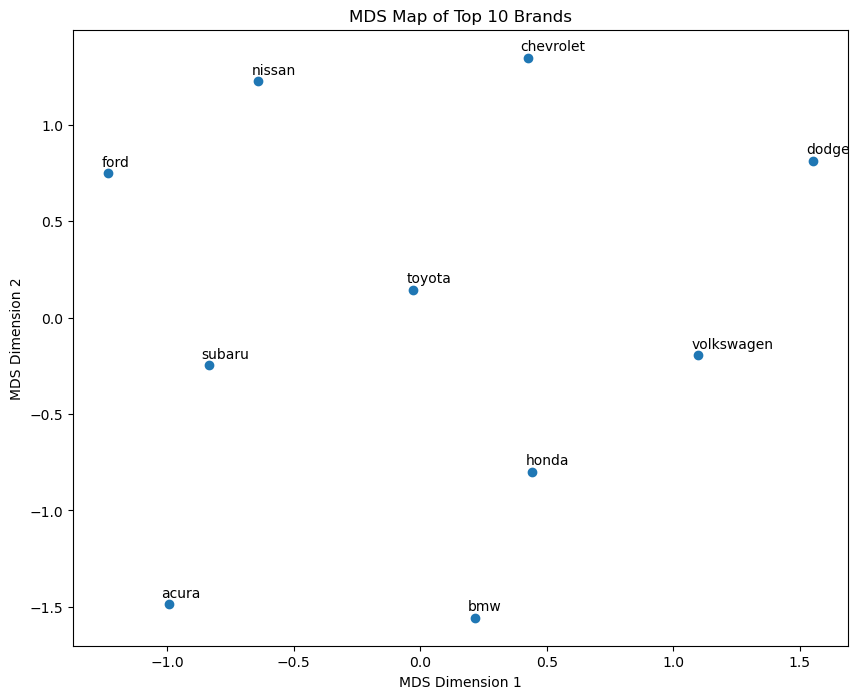

In [12]:
import pandas as pd
from collections import Counter
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

# Calculate Lift Ratios
def calculate_lift(brand1, brand2, data):
    total_posts = len(data)
    brand1_count = sum(brand1 in brands for brands in data['Brands Mentioned'])
    brand2_count = sum(brand2 in brands for brands in data['Brands Mentioned'])
    both_count = sum(brand1 in brands and brand2 in brands for brands in data['Brands Mentioned'])
    return (total_posts * both_count) / (brand1_count * brand2_count) if brand1_count and brand2_count else 0

lift_matrix = pd.DataFrame(index=top_10_brands, columns=top_10_brands)
lift_ratios = []

# Only calculate lift for unique brand pairs
for i, brand1 in enumerate(top_10_brands):
    for brand2 in top_10_brands[i+1:]:
        lift = calculate_lift(brand1, brand2, forum_data)
        lift_matrix.loc[brand1, brand2] = lift
        lift_matrix.loc[brand2, brand1] = lift  # Symmetric
        lift_ratios.append((brand1, brand2, lift))

# Create a DataFrame for lift ratios
lift_df = pd.DataFrame(lift_ratios, columns=['Brand 1', 'Brand 2', 'Lift Ratio'])
lift_df = lift_df.sort_values(by='Lift Ratio', ascending=False).reset_index(drop=True)

# Display the DataFrame of lift ratios
print("Lift Ratios between Brand Pairs:")
print(lift_df)

# Replace NaN values in the lift matrix with 1 (indicating no lift)
lift_matrix = lift_matrix.fillna(1)

# Multidimensional Scaling (MDS)
mds = MDS(n_components=2, random_state=0)
mds_coords = mds.fit_transform(lift_matrix)

# Plot MDS map
plt.figure(figsize=(10, 8))
plt.scatter(mds_coords[:, 0], mds_coords[:, 1], marker='o')
for label, x, y in zip(top_10_brands, mds_coords[:, 0], mds_coords[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(-5, 5), textcoords='offset points')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('MDS Map of Top 10 Brands')
plt.show()